<a href="https://colab.research.google.com/github/alexgil3/A-neural-network-performance-analysis-with-three-different-model-structures/blob/main/TFG_Convolutional_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Put file path as a string here
CIFAR_DIR = 'C:/Users/aleja/cifar-10-batches-py/'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from timeit import default_timer as timer
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, Dense, Lambda

In [ ]:
tf.__version__

'1.10.0'

In [ ]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # write -1 to use CPU or write 0 to use GPU
import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1426571830698031144
]


In [ ]:
#Function grabbed from the official CIFAR 10 webpage
#https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [ ]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [ ]:
all_data = [0,1,2,3,4,5,6]

In [ ]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [ ]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [ ]:
data_batch1.keys()

dict_keys([b'filenames', b'batch_label', b'labels', b'data'])

In [ ]:
X = data_batch1[b"data"] 

In [ ]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [ ]:
X[0].max()

255

In [ ]:
(X[0]/255).max()

1.0

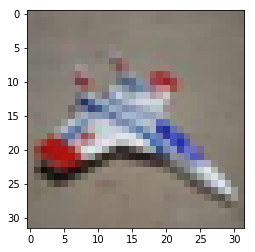

In [ ]:
plt.imshow(X[30])

In [ ]:
print(X.shape)

(10000, 32, 32, 3)


In [ ]:
#Converts categorical values into binary values
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [ ]:
class CifarHelper():
    
    def __init__(self):
        #Couter: used later for counting batches
        self.i = 0
        
        #List of batches
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    #This function manipulates both training an test images in order to pass them as an input for our model
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")

        #Stacks the arrays from "data" (each image) vertically
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches]) 

        #Number of training images
        train_len = len(self.training_images)
        
        #Reshape the images as a 32x32 images with 3 color channels so their dimension should be (32,32,3)
        #The images are also normalized "/255" as 255 is the maximum value
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255

        #Use one hot ecoding. This is essential for the model to work properly
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Training images: Done\n")

        print("Setting Up Test Images and Labels")
        #Stacks the arrays from "data" (each image) vertically
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])

        #Number of test images
        test_len = len(self.test_images)
        
        #Reshape the images as a 32x32 images with 3 color channels so their dimension should be (32,32,3)
        #The images are also normalized "/255" as 255 is the maximum value
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255

        #Use one hot ecoding. This is essential for the model to work properly
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
        print("Test images: Done")



    #This function should be called at the end of each batch.
    #It goes through the data array with steps of batch_size
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,32,32,3) #100 is the batch_size  CHANGE THIS LATER
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images) #
        return x, y

In [ ]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Training images: Done

Setting Up Test Images and Labels
Test images: Done


In [ ]:
#Create placeholders (None: batch size)
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [ ]:
#This will be a single number used for the dropout
hold_prob = tf.placeholder(tf.float32)

In [ ]:
#Init all the weights using truncated normal
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### **CPU vs. GPU**

In [ ]:
def create_model():
  #First layer and pooling
  convo_1 = convolutional_layer(x,shape=[4,4,3,32])
  convo_1_pooling = max_pool_2by2(convo_1)

  #First layer and pooling
  convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
  convo_2_pooling = max_pool_2by2(convo_2)

  #Flat second layer
  convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

  #Apply activation funciton 
  full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

  #Apply dropout
  full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

  #Create last layer as a fully coonnected layer
  y_pred = normal_full_layer(full_one_dropout,10)

  #Create loss function
  cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

  #Optinizer
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train = optimizer.minimize(cross_entropy)

  return y_pred, train

In [ ]:
#Init variables
init = tf.global_variables_initializer()

In [ ]:
def train_model(y_pred, train, batch_size):
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    start = timer()
    for i in range(batch_size*5):
      batch = ch.next_batch(batch_size)
      sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
      # PRINT OUT A MESSAGE EVERY 100 STEPS
      if i%100 == 0:
            
        print('Currently on step {}'.format(i))
        print('Accuracy is:')
        # Test the Train Model
        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

        acc = tf.reduce_mean(tf.cast(matches,tf.float32))

        print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
        print('\n')
    end = timer()

  return end-start   

In [ ]:
av_time = 0
num_iter = 5
results_time = np.zeros(num_iter)
for i in range(num_iter):
  print('training iteration:',i)
  y_pred, model = create_model()

  # Before Your tf.Session run these two lines
  ch = CifarHelper()
  ch.set_up_images()

  time = train_model(y_pred, model,100)
  av_time += time
  results_time[i] = time

  del ch
  del model

av_time/=num_iter

training iteration: 0
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Setting Up Training Images and Labels
Training images: Done

Setting Up Test Images and Labels
Test images: Done
Currently on step 0
Accuracy is:
0.1001


Currently on step 100
Accuracy is:
0.4221


Currently on step 200
Accuracy is:
0.4828


Currently on step 300
Accuracy is:
0.5061


Currently on step 400
Accuracy is:
0.5256


training iteration: 1
Setting Up Training Images and Labels
Training images: Done

Setting Up Test Images and Labels
Test images: Done
Currently on step 0
Accuracy is:
0.1083


Currently on step 100
Accuracy is:
0.4134


Currently on step 200
Accuracy is:
0.4671


Currently on step 300
Accuracy is:
0.492


Currently on step 400
Accuracy is:
0.5233


training iteration: 2
Setting Up Training Images and Labels
Training images: Done

Setting Up Test Imag

In [ ]:
max = np.nanmax(results_time,axis=0)
min = np.nanmin(results_time,axis=0)
res = max - min
res

8.5935072000000616

No handles with labels found to put in legend.


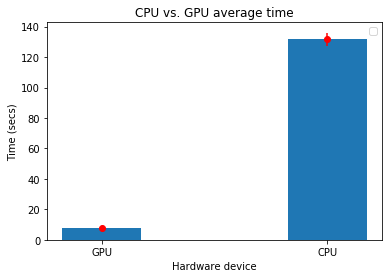

In [ ]:
#Average with batch_size = 100, steps = 500, run 5 times
data = (8.04, 131.71)
err = (2.23/2 ,8.59/2 )
ind = np.arange(2)
width = 0.35

plt.bar(ind, data, width)
plt.errorbar(ind, data,yerr=err, fmt="o", color="r")
plt.title('CPU vs. GPU average time')
plt.xlabel('Hardware device')
plt.ylabel('Time (secs)')

plt.legend(loc='best')
plt.xticks(ind, ('GPU','CPU'))
plt.show()

### **Train batch size**

In [ ]:
def train_model_accuracy(y_pred, train, batch_size):

  num_iter = 20
  results_accuracy = np.zeros(num_iter)
  cont = 0
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    start = timer()
    for i in range(2000):
      batch = ch.next_batch(batch_size)
      sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
      # PRINT OUT A MESSAGE EVERY 100 STEPS
      if i%100 == 0: 
        print('Currently on step {}'.format(i))
        print('Accuracy is:')
        # Test the Train Model
        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

        acc = tf.reduce_mean(tf.cast(matches,tf.float32))
        results_accuracy[cont] = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
        cont+=1
        print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
        print('\n')
    end = timer()
    time = end-start

  return time, results_accuracy

In [ ]:
av_time = 0
num_iter = 1
for i in range(num_iter):
  print('training iteration:',i)
  y_pred, model = create_model()
  y_pred_2, model_2 = create_model()
  y_pred_3, model_3 = create_model()
  y_pred_4, model_4 = create_model()
  

  # Before Your tf.Session run these two lines
  ch = CifarHelper()
  ch.set_up_images()
  time, accuracy = train_model_accuracy(y_pred, model,80)
  time_2, accuracy_2 = train_model_accuracy(y_pred, model,100)
  time_3, accuracy_3 = train_model_accuracy(y_pred, model,250)
  time_4, accuracy_4 = train_model_accuracy(y_pred, model,500)
  av_time += time

  del ch
  del model

av_time/=num_iter

training iteration: 0
Setting Up Training Images and Labels
Training images: Done

Setting Up Test Images and Labels
Test images: Done
Currently on step 0
Accuracy is:
0.0995


Currently on step 100
Accuracy is:
0.4025


Currently on step 200
Accuracy is:
0.4516


Currently on step 300
Accuracy is:
0.4845


Currently on step 400
Accuracy is:
0.5131


Currently on step 500
Accuracy is:
0.5282


Currently on step 600
Accuracy is:
0.5403


Currently on step 700
Accuracy is:
0.539


Currently on step 800
Accuracy is:
0.5882


Currently on step 900
Accuracy is:
0.5863


Currently on step 1000
Accuracy is:
0.6066


Currently on step 1100
Accuracy is:
0.6132


Currently on step 1200
Accuracy is:
0.6306


Currently on step 1300
Accuracy is:
0.639


Currently on step 1400
Accuracy is:
0.6347


Currently on step 1500
Accuracy is:
0.6475


Currently on step 1600
Accuracy is:
0.6283


Currently on step 1700
Accuracy is:
0.64


Currently on step 1800
Accuracy is:
0.6487


Currently on step 1900
Acc

In [ ]:
accuracy

array([ 0.0995    ,  0.4025    ,  0.45159999,  0.48449999,  0.51310003,
        0.52819997,  0.54030001,  0.53899997,  0.58819997,  0.58630002,
        0.60659999,  0.61320001,  0.63059998,  0.639     ,  0.6347    ,
        0.64749998,  0.62830001,  0.63999999,  0.6487    ,  0.6663    ])

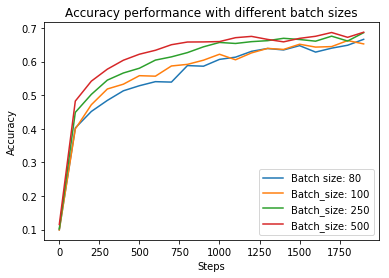

In [ ]:
#  One training 20 steps of different batchsize
x = np.arange(0,2000,100)
plt.plot(x,accuracy, label = 'Batch size: 80')
plt.plot(x,accuracy_2, label = 'Batch_size: 100')
plt.plot(x,accuracy_3, label = 'Batch_size: 250')
plt.plot(x,accuracy_4, label = 'Batch_size: 500')

plt.title('Accuracy performance with different batch sizes')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

No handles with labels found to put in legend.


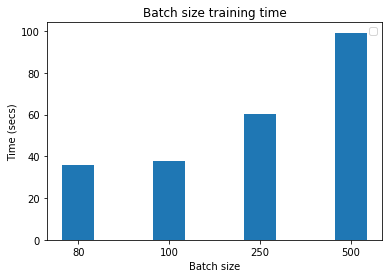

In [ ]:
#Average with batch_size = 100, steps = 500, run 5 times
data = (time, time_2, time_3, time_4)

ind = np.arange(4)
width = 0.35

plt.bar(ind, data, width)

plt.title('Batch size training time')
plt.xlabel('Batch size')
plt.ylabel('Time (secs)')

plt.legend(loc='best')
plt.xticks(ind, ('80','100','250','500'))
plt.show()

### **Train optimizer**

In [ ]:
def create_model_optimizer(optimizer):
  #First layer and pooling
  convo_1 = convolutional_layer(x,shape=[4,4,3,32])
  convo_1_pooling = max_pool_2by2(convo_1)

  #First layer and pooling
  convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
  convo_2_pooling = max_pool_2by2(convo_2)

  #Flat second layer
  convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

  #Apply activation funciton 
  full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

  #Apply dropout
  full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

  #Create last layer as a fully coonnected layer
  y_pred = normal_full_layer(full_one_dropout,10)

  #Create loss function
  cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

  #Optinizer
  if optimizer == 'GradientDescentOptimizer':
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

  elif optimizer == 'AdamOptimizer':
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

  elif optimizer == 'RMSPropOptimizer':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

  elif optimizer == 'AdadeltaOptimizer':
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.001)
  
  train = optimizer.minimize(cross_entropy)

  return y_pred, train

In [ ]:
av_time = 0
num_iter = 1
for i in range(num_iter):
  print('training iteration:',i)
  y_pred_op, model_op = create_model_optimizer('GradientDescentOptimizer')
  y_pred_op_2, model_op_2 = create_model_optimizer('AdamOptimizer')
  y_pred_op_3, model_op_3 = create_model_optimizer('RMSPropOptimizer')
  y_pred_op_4, model_op_4 = create_model_optimizer('AdadeltaOptimizer')
  

  # Before Your tf.Session run these two lines
  ch = CifarHelper()
  ch.set_up_images()
  time, accuracy = train_model_accuracy(y_pred_op, model_op,100)
  time_2, accuracy_2 = train_model_accuracy(y_pred_op_2, model_op_2,100)
  time_3, accuracy_3 = train_model_accuracy(y_pred_op_3, model_op_3,100)
  time_4, accuracy_4 = train_model_accuracy(y_pred_op_4, model_op_4,100)
  av_time += time

  del ch

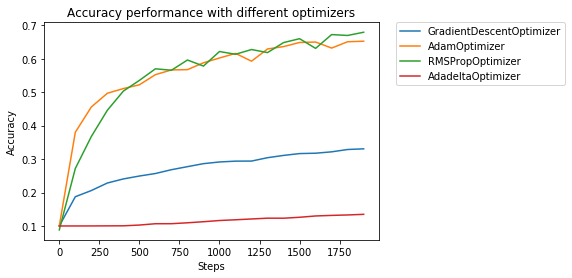

In [ ]:
#  One training 20 steps of different optimizers
x = np.arange(0,2000,100)
plt.plot(x,accuracy, label = 'GradientDescentOptimizer')
plt.plot(x,accuracy_2, label = 'AdamOptimizer')
plt.plot(x,accuracy_3, label = 'RMSPropOptimizer')
plt.plot(x,accuracy_4, label = 'AdadeltaOptimizer')

plt.title('Accuracy performance with different optimizers')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

No handles with labels found to put in legend.


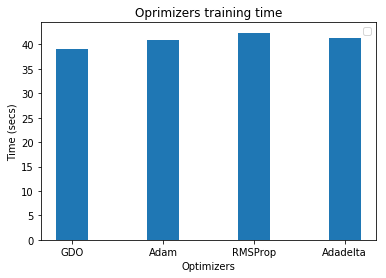

In [ ]:
#Average with batch_size = 100, steps = 500, run 5 times
data = (time, time_2, time_3, time_4)

ind = np.arange(4)
width = 0.35

plt.bar(ind, data, width)

plt.title('Oprimizers training time')
plt.xlabel('Optimizers')
plt.ylabel('Time (secs)')

plt.legend(loc='best')
plt.xticks(ind, ('GDO','Adam','RMSProp','Adadelta'))
plt.show()

### **Train num_layers**

In [ ]:
def create_model_layers(num_layers):


  #First layer and pooling
  convo_1 = convolutional_layer(x,shape=[4,4,3,32])
  convo_1_pooling = max_pool_2by2(convo_1)

  for i in range(num_layers-1):
    #Second layer and pooling
    if i == 0:
      convo = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
    else:
      convo = convolutional_layer(convo_pooling,shape=[4,4,64,64])

    convo_pooling = max_pool_2by2(convo)

  if num_layers ==1:
    print(convo_1_pooling.shape.dims)

  else:
    print(convo_pooling.shape.dims)

#pow(2,5 + i)
  
  ind  = 16
  if num_layers == 2:
    ind = 8
  if num_layers == 3:
    ind = 4
  elif num_layers == 4:
    ind = 2
  elif num_layers > 4:
    ind = 1


  if num_layers ==1:
     #Flat first layer
     convo_flat = tf.reshape(convo_1_pooling,[-1,ind*ind*32])

  else:
    #Flat second to last layer
    convo_flat = tf.reshape(convo_pooling,[-1,ind*ind*64])

  #Apply activation funciton 
  full_layer_one = tf.nn.relu(normal_full_layer(convo_flat,1024))

  #Apply dropout
  full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

  #Create last layer as a fully coonnected layer
  y_pred = normal_full_layer(full_one_dropout,10)

  #Create loss function
  cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

  #Optinizer
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train = optimizer.minimize(cross_entropy)

  return y_pred, train

In [ ]:
av_time = 0
num_iter = 1
for i in range(num_iter):
  print('training iteration:',i)

  y_pred_po,   model_po =     create_model_layers(1)
  y_pred_po_2, model_po_2 =   create_model_layers(2)
  y_pred_po_3, model_po_3 =   create_model_layers(3)
  y_pred_po_4, model_po_4 =   create_model_layers(4)
  y_pred_po_5, model_po_5 =   create_model_layers(5)
  y_pred_po_10,model_po_10 =  create_model_layers(10)
  y_pred_po_20,model_po_20 =  create_model_layers(20)

  # Before Your tf.Session run these two lines
  ch = CifarHelper()
  ch.set_up_images()


  time, accuracy =       train_model_accuracy(y_pred_po, model_po,100)
  time_2, accuracy_2 =   train_model_accuracy(y_pred_po_2, model_po_2,100)
  time_3, accuracy_3 =   train_model_accuracy(y_pred_po_3, model_po_3,100)
  time_4, accuracy_4 =   train_model_accuracy(y_pred_po_4, model_po_4,100)
  time_5, accuracy_5 =   train_model_accuracy(y_pred_po_5, model_po_5,100)
  time_10, accuracy_10 = train_model_accuracy(y_pred_po_10, model_po_10,100)
  time_20, accuracy_20 = train_model_accuracy(y_pred_po_20, model_po_20,100)

  av_time += time

  del ch

training iteration: 0
[Dimension(None), Dimension(16), Dimension(16), Dimension(32)]
[Dimension(None), Dimension(8), Dimension(8), Dimension(64)]
[Dimension(None), Dimension(4), Dimension(4), Dimension(64)]
[Dimension(None), Dimension(2), Dimension(2), Dimension(64)]
[Dimension(None), Dimension(1), Dimension(1), Dimension(64)]
[Dimension(None), Dimension(1), Dimension(1), Dimension(64)]
[Dimension(None), Dimension(1), Dimension(1), Dimension(64)]
Setting Up Training Images and Labels
Training images: Done

Setting Up Test Images and Labels
Test images: Done
Currently on step 0
Accuracy is:
0.1


Currently on step 100
Accuracy is:
0.3961


Currently on step 200
Accuracy is:
0.4617


Currently on step 300
Accuracy is:
0.4773


Currently on step 400
Accuracy is:
0.508


Currently on step 500
Accuracy is:
0.5306


Currently on step 600
Accuracy is:
0.5506


Currently on step 700
Accuracy is:
0.5537


Currently on step 800
Accuracy is:
0.5562


Currently on step 900
Accuracy is:
0.5809


Cu

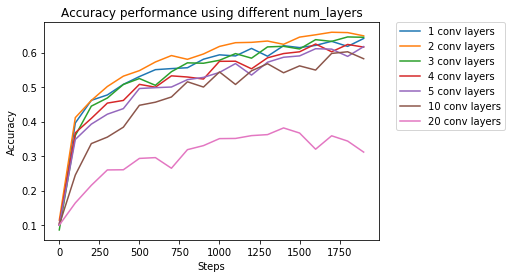

In [ ]:
#  One training 20 steps of different number of layers
#100 batch size 
x = np.arange(0,2000,100)
plt.plot(x,accuracy, label =    '1 conv layers')
plt.plot(x,accuracy_2, label =  '2 conv layers')
plt.plot(x,accuracy_3, label =  '3 conv layers')
plt.plot(x,accuracy_4, label =  '4 conv layers')
plt.plot(x,accuracy_5, label =  '5 conv layers')
plt.plot(x,accuracy_10, label = '10 conv layers')
plt.plot(x,accuracy_20, label = '20 conv layers')

plt.title('Accuracy performance using different num_layers')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

No handles with labels found to put in legend.


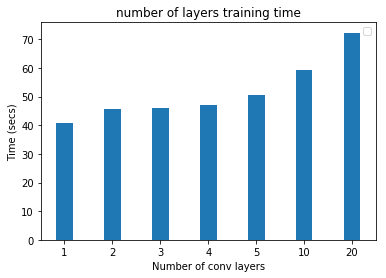

In [ ]:
#Average with batch_size = 100, steps = 500, run 5 times
data = (time, time_2, time_3, time_4, time_5, time_10, time_20)

ind = np.arange(7)
width = 0.35

plt.bar(ind, data, width)

plt.title('number of layers training time')
plt.xlabel('Number of conv layers')
plt.ylabel('Time (secs)')

plt.legend(loc='best')
plt.xticks(ind, ('1','2','3','4','5','10','20'))
plt.show()